<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/ionosphere_scale"
nbfeatures = 34
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6)
df_train = hcat(xtr, ytr)
# low_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);

In [2]:
# rate = 0.2
# sx = rate*size(low_train[low_train[:, end] .> 0, :])[1]/(size(low_train[low_train[:, end] .< 0, :])[1]*(1-rate))
# low_data = low_train[low_train[:, end] .< 0, :]
# xltr, xlte, yltr, ylte = train_test_split(low_data[:,1:end-1], low_data[:,end], train_size = sx)
# low_low = hcat(xltr, yltr)
# df_train = vcat(low_low,low_train[low_train[:, end] .> 0, :]);
# println(size(low_train[low_train[:, end] .< 0, :])[1]/size(low_train)[1])
# println(size(df_train[df_train[:, end] .< 0, :])[1]/size(df_train)[1])
# println(size(df_aux[df_aux[:, end] .< 0, :])[1]/size(df_aux)[1])

In [3]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 50
itmax = 2000
sample = 100

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [4]:
# Séparer à la main entre label 1 et 0 et regarder les fréquences de chacun
# Fraude bancaire avec faux positifs
# Avec erreur de 0.01% changer le label. Mislabelled training dataset (regarder papier sur le sujet)

In [5]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.0185185, 0.037037, 0.037037, 0.0555556, 0.0555556, 0.0925926, 0.0925926, 0.111111, 0.111111  …  0.37037, 0.425926, 0.425926, 0.444444, 0.444444, 0.462963, 0.462963, 0.481481, 0.481481, 1.0], [0.0, 0.0, 0.0, 0.045977, 0.045977, 0.0689655, 0.0689655, 0.114943, 0.114943, 0.137931  …  0.862069, 0.862069, 0.908046, 0.908046, 0.91954, 0.91954, 0.988506, 0.988506, 1.0, 1.0], [2.0, 1.0, 0.999998, 0.999883, 0.999843, 0.99952, 0.999481, 0.999135, 0.999135, 0.998645  …  0.784435, 0.730877, 0.672388, 0.601937, 0.491969, 0.463416, 0.273561, 0.247129, 0.164647, 3.69296e-12])

In [4]:
xKL = KL_opt(df_train, 0.001, solver, robustModel.regressionModel)

34-element Array{Float64,1}:
 -0.203607
  0.0     
 -0.287373
  3.4018  
  4.43753 
 -0.40554 
 -1.19641 
  2.30536 
  1.489   
 -0.383617
 -0.23382 
 -2.28823 
 -3.31175 
  ⋮       
  0.22893 
  0.524757
  0.895797
  3.34307 
 -6.46858 
  0.541407
  4.57825 
  0.157984
  1.41263 
  1.15703 
  0.216224
 -2.38439 

In [ ]:
xWAS = DRO_opt(df_train, 0.001, solver, robustModel.regressionModel)

In [6]:
e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]

14-element Array{Float64,1}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.05 
 0.1  
 0.5  
 1.0  

In [7]:
dm_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, KLConstraint())
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.001
 
50 0.04768230478500651 100 0.015979887617765365 150 0.023676621826581257 200 0.023347356522986917 250 0.056188217512977756 300 0.015050590460378821 350 0.04309666025703218 400 0.04019416371120976 450 0.02753122363647864 500 0.024457895971653487 550 0.014657188710773594 600 0.012743317663529652 650 0.017858740360669367 700 0.024543387805380013 750 0.014622429598489806 800 0.01809939786890702 850 0.010566273191246367 900 0.01901542959552982 950 0.027074152051627554 1000 0.015431173245965324 1050 0.0168318077539249 1100 0.00593529490140865 1150 0.04643857661527084 1200 0.0106859991508087 1250 0.017016023136279035 1300 0.006885711400611116 1350 0.016699711301656817 1400 0.013679718920709849 1450 0.015063311547566238 1500 0.023582216303535963 1550 0.012469700996605937 1600 0.017844009439199837 1650 0.010616078735717238 1700 0.010827182835882798 1750 0.017326649332433552 1800 0.01748853129944028 1850 0.025884028335239062 1900 0.025283522166803518 1950 0.01842724228985615 

50 0.05328704960016062 100 0.017733864238746344 150 0.085043028175247 200 0.025441000006956482 250 0.04415554827182078 300 0.025419452783525198 350 0.021587377957827503 400 0.052007093108792146 450 0.025453506630936262 500 0.03301642591392562 550 0.07004611079123557 600 0.05592360007926511 650 0.02611056593213701 700 0.028946097043581753 750 0.0349866015090996 800 0.03712518217516059 850 0.015191081860890243 900 0.023274609068794083 950 0.011418130164299711 1000 0.012218058940344001 1050 0.04749025620870784 1100 0.039411666542131796 1150 0.028852429020245207 1200 0.020013284793166886 1250 0.04605848020690062 1300 0.01975031871185673 1350 0.018089521362627536 1400 0.06612383679610945 1450 0.027574699818239568 1500 0.04213840199019936 1550 0.02857036124064849 1600 0.059522272569207946 1650 0.01998187318050848 1700 0.020122500965765955 1750 0.042637361207817914 1800 0.06949227454990936 1850 0.0454231406878991 1900 0.03831331195152132 1950 0.03488679243289128 2000 0.03293976274521837  
esp

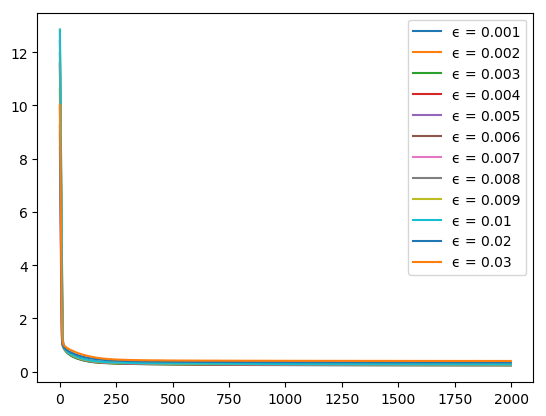

PyObject <matplotlib.legend.Legend object at 0x7f1219af4c88>

In [31]:
for i in 1:12
     plot(dm_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

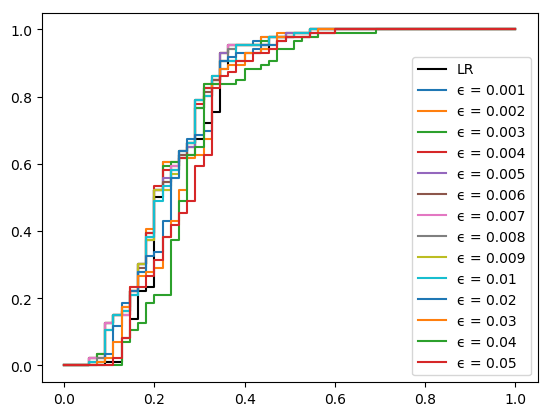

PyObject <matplotlib.legend.Legend object at 0x7f1219f5fe10>

In [25]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:14
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

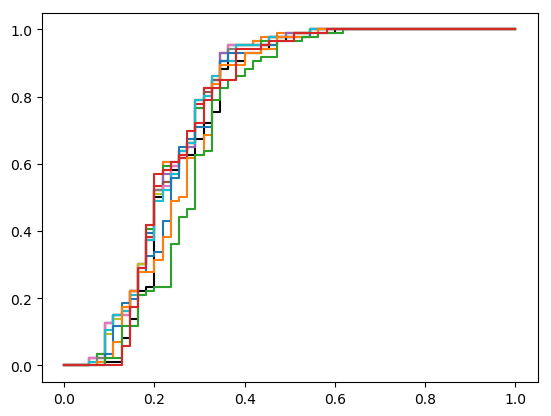

In [32]:
plot(fpr,tpr, color="black")
for i in 1:14
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [33]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end

0.7463002114164905  0.7943262411347518
0.7733615221987314  0.8085106382978723
0.7735729386892178  0.8085106382978723
0.7723044397463001  0.8085106382978723
0.7716701902748415  0.8085106382978723
0.771247357293869  0.8085106382978723
0.7699788583509514  0.8014184397163121
0.7701902748414376  0.8014184397163121
0.7689217758985201  0.8014184397163121
0.768076109936575  0.8014184397163121
0.7674418604651163  0.8014184397163121
0.7539112050739958  0.7943262411347518
0.7408033826638478  0.7872340425531915
0.718816067653277  0.7659574468085106
0.7300211416490485  0.7872340425531915


In [34]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_tab[i], LogisticRegression())))
end

0.7463002114164905  0.7943262411347518
0.772938689217759  0.8085106382978723
0.7739957716701903  0.8085106382978723
0.7723044397463001  0.8085106382978723
0.7714587737843552  0.8085106382978723
0.771247357293869  0.8085106382978723
0.7701902748414376  0.8014184397163121
0.7701902748414376  0.8014184397163121
0.7689217758985201  0.8014184397163121
0.7674418604651163  0.8014184397163121
0.7668076109936575  0.8014184397163121
0.7547568710359408  0.8014184397163121
0.7422832980972516  0.7872340425531915
0.7177589852008457  0.7801418439716312
0.7579281183932346  0.8014184397163121


In [13]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
# @everywhere solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
# @everywhere ϵ = 0.05
verbosity = 1
itmax = 500
sample = 128

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(1000), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [14]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

([0.0, 0.0181818, 0.0909091, 0.0909091, 0.127273, 0.127273, 0.145455, 0.145455, 0.163636, 0.163636  …  0.472727, 0.490909, 0.490909, 0.545455, 0.545455, 0.6, 0.6, 0.654545, 0.690909, 1.0], [0.0, 0.0, 0.0, 0.0116279, 0.0116279, 0.0813953, 0.0813953, 0.139535, 0.139535, 0.22093  …  0.965116, 0.965116, 0.976744, 0.976744, 0.988372, 0.988372, 1.0, 1.0, 1.0, 1.0], [2.0, 1.0, 0.999996, 0.999985, 0.999949, 0.999721, 0.999708, 0.999371, 0.998804, 0.997645  …  0.366902, 0.207207, 0.202421, 0.045397, 0.0183901, 0.0020542, 0.00161377, 0.000318146, 0.00022649, 6.27762e-14])

In [15]:
e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,
        0.05,0.06,0.07,0.08,0.09,0.1,0.5,1.0]

21-element Array{Float64,1}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.1  
 0.5  
 1.0  

In [16]:
dm_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,
        0.05,0.06,0.07,0.08,0.09,0.1,0.5,1.0]
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.001
 
1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 137 0.0 138 0.0 139 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 2.814208759249759e-6 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 3.921438493259544e-6 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 13

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 137 0.0 138 0.0 139 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 137 0.0 138 0.0 139 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 137 0.0 138 0.0 139 

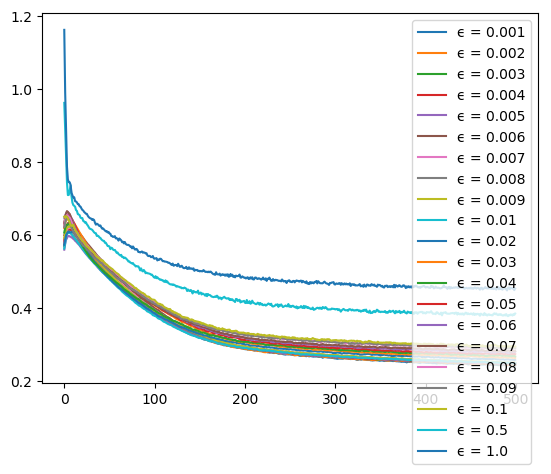

PyObject <matplotlib.legend.Legend object at 0x7f12199ba240>

In [35]:
for i in 1:21
     plot(dm_was[i], label="ϵ = $(e_tab[i])")
end
legend()

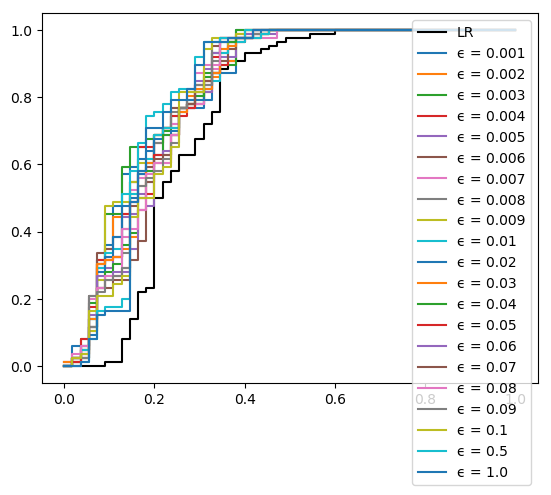

PyObject <matplotlib.legend.Legend object at 0x7f12198aef28>

In [36]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:21
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
legend()

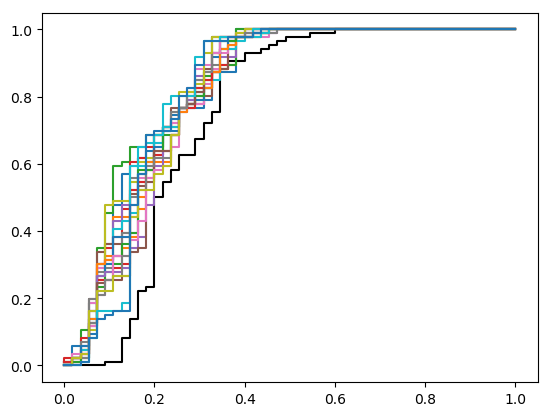

In [37]:
plot(fpr,tpr, color="black")
for i in 1:21
     plot(fpr2_was[i], tpr2_was[i])
end

In [20]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

In [38]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end

0.7463002114164905  0.7943262411347518
0.8291754756871036  0.8297872340425532
0.8257928118393235  0.8156028368794326
0.8357293868921776  0.8226950354609929
0.8257928118393235  0.8226950354609929
0.8164904862579281  0.8156028368794326
0.8238900634249472  0.8156028368794326
0.8202959830866808  0.8226950354609929
0.8232558139534883  0.8226950354609929
0.8310782241014799  0.8156028368794326
0.8251585623678647  0.8156028368794326
0.825369978858351  0.8226950354609929
0.8133192389006342  0.8156028368794326
0.8173361522198732  0.8156028368794326
0.8128964059196617  0.8226950354609929
0.8109936575052854  0.8085106382978723
0.8078224101479915  0.8156028368794326
0.8162790697674419  0.8085106382978723
0.8152219873150106  0.8226950354609929
0.8116279069767441  0.8156028368794326
0.8274841437632134  0.8226950354609929
0.8200845665961944  0.8297872340425532


In [39]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_was[i], LogisticRegression())))
end

0.7463002114164905  0.7943262411347518
0.8291754756871036  0.8297872340425532
0.8219873150105709  0.8156028368794326
0.8414376321353066  0.8226950354609929
0.828752642706131  0.8297872340425532
0.8226215644820296  0.8156028368794326
0.8232558139534883  0.8156028368794326
0.8202959830866808  0.8226950354609929
0.8236786469344609  0.8226950354609929
0.8310782241014799  0.8156028368794326
0.8219873150105709  0.8156028368794326
0.8202959830866808  0.8226950354609929
0.8133192389006342  0.8156028368794326
0.8173361522198732  0.8156028368794326
0.8171247357293868  0.8226950354609929
0.810570824524313  0.8156028368794326
0.8103594080338266  0.8156028368794326
0.8128964059196617  0.8085106382978723
0.817970401691332  0.8085106382978723
0.8141649048625793  0.8156028368794326
0.8230443974630022  0.8226950354609929
0.8164904862579281  0.8297872340425532


In [23]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
println(classification_report(df_aux[:,end], pred(df_aux, xr1_was[3], LogisticRegression())))

             precision    recall  f1-score   support

       -1.0       0.84      0.58      0.69        55
        1.0       0.78      0.93      0.85        86

avg / total       0.80      0.79      0.78       141

             precision    recall  f1-score   support

       -1.0       1.00      0.55      0.71        55
        1.0       0.77      1.00      0.87        86

avg / total       0.86      0.82      0.81       141



In [ ]:
N = size(df_train)[1]
verbosity = 1
itmax = 2000
sample = 100

ambiguity = "entropic"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)

projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [ ]:
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
x0 = x0 = initialize(df_train, robustModel, EntropicConstraint())
xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
xrobust2 = getsolution(mem, ambiguity, nbfeatures)
fpr1_ent, tpr1_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
fpr2_ent, tpr2_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))

In [ ]:
plot(dm)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr1_ent, tpr1_ent)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr2_ent, tpr2_ent)

In [ ]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust1,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust2,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
pred(df_aux, xrobust2, LogisticRegression())

In [24]:
open("io20-opt.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
    write(f, "dm_tab = ")
    write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
    write(f, "dm_was = ")
    write(f, "$dm_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
#     write(f, "dm = ")
#     write(f, "$dm \n")
#     write(f, "xrobuts1 = ")
#     write(f, "$xrobuts1 \n")
#     write(f, "fpr1_ent = ")
#     write(f, "$fpr1_ent \n")
#     write(f, "tpr1_ent = ")
#     write(f, "$tpr1_ent \n")
end

8067